# Visualization of AdamMCMC

This notebook provides an interactive visualization of the optimization trajectories produced by AdamMCMC. Visualizing it in 2D and comparing it to stanard Adam helps build intuition for its behavior.

Inspired by: [Interactive Visualization of Optimization Algorithms in Deep Learning](https://emiliendupont.github.io/2018/01/24/optimization-visualization/)

In [188]:
from math import exp

from jax import grad, jit
from jax.numpy import exp as jexp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.stats import multivariate_normal

%matplotlib widget

Define the function to be optimized with its gradients, here
$$
f(x,y)
= -2\,\exp\!\left(-\frac{(x-1)^2 + y^2}{0.2}\right)
\;-\;3\,\exp\!\left(-\frac{(x+1)^2 + y^2}{0.2}\right)
\;+\;x^2 + y^2 .
$$

In [189]:
domain_x = (-2.0, 2.0)
domain_y = (-2.0, 2.0)
domain_f = (-3.0, 9.0)

def in_domain(x):
    return (domain_x[0] <= x[0] <= domain_x[1]) and (domain_y[0] <= x[1] <= domain_y[1])

def f(x, y):
    return (
        -2.0 * jexp(-(((x - 1.0) ** 2 + y**2) / 0.2))
        -3.0 * jexp(-(((x + 1.0) ** 2 + y**2) / 0.2))
        + x**2
        + y**2
    )

_grad_jit = jit(grad(f, argnums=(0, 1)))  # returns (df/dx, df/dy)

def grad_f(x, y):
    gx, gy = _grad_jit(x, y)
    return np.array([gx, gy], dtype=float)

Set Adam hyperparameters, a number of burn in steps can be defined here

In [190]:
# orig
learning_rate = 1e-2
num_steps = 100
burnin = 0
beta_1 = 0.7
beta_2 = 0.999
eps = 1e-6

In [191]:
# MCMC
learning_rate = 1e-2
num_steps = 200
burnin = 100
beta_1 = 0.9
beta_2 = 0.9
eps = 1e-8

**Adam** - Standard optimizer implementation

In [192]:
def get_adam_path(x0, y0, sigma=None, sigma_g=None):
    m = np.zeros(2, dtype=float)
    v = np.zeros(2, dtype=float)
    path = np.zeros((num_steps + burnin + 1, 2), dtype=float)
    path[0] = [x0, y0]

    x = np.array([x0, y0], dtype=float)
    for t in range(num_steps + burnin):
        g = grad_f(x[0], x[1])
        m = beta_1 * m + (1.0 - beta_1) * g
        v = beta_2 * v + (1.0 - beta_2) * (g * g)
        x = x - learning_rate * m / (np.sqrt(v) + eps)
        path[t + 1] = x
    return path

**AdamMCMC** - as implemented in [Bieringer et al. (2024)](https://arxiv.org/abs/2312.14027)

In [193]:
lam = 1
sigma = 0.1
sigma_g = 1.0

def get_u(t, m_1, m_2):
    m_1 = m_1 / (1 - beta_1**(t + 1))
    m_2 = m_2 / (1 - beta_2**(t + 1))
    return learning_rate * m_1 / (np.sqrt(m_2) + eps)

def get_covar(u, sigma, sigma_g):
    u = u[None, :]
    return sigma * sigma * np.eye(2) + sigma_g * sigma_g * u.T @ u

In [194]:
def get_adammcmc_path(x0, y0, sigma=sigma, sigma_g=sigma_g):
    m_1 = np.zeros(2, dtype=float)
    m_2 = np.zeros(2, dtype=float)
    path = np.zeros((num_steps + burnin + 1, 2), dtype=float)
    path[0] = [x0, y0]

    theta = np.array([x0, y0], dtype=float)
    for t in range(num_steps + burnin):
        g = grad_f(theta[0], theta[1])
        m_1 = beta_1 * m_1 + (1.0 - beta_1) * g
        m_2 = beta_2 * m_2 + (1.0 - beta_2) * (g * g)
        u = get_u(t, m_1, m_2)

        theta_tilde = theta - u
        covar = get_covar(u, sigma, sigma_g)
        tau = np.random.multivariate_normal(theta_tilde, covar)
        tau_tilde = tau - u

        if in_domain(tau):
            A = exp(-lam * f(tau[0], tau[1])) / exp(-lam * f(theta[0], theta[1]))
            B = multivariate_normal.pdf(theta, mean=tau_tilde, cov=covar) / multivariate_normal.pdf(tau, mean=theta_tilde, cov=covar)
            alpha = A * B

            if alpha >= np.random.uniform(0.0, 1.0):
                theta = tau
                
        path[t + 1] = theta
    return path

**AdamMCMC\*** - Variation of AdamMCMC without assumptions on the reverse step, which is calculated as if it being the next step

In [195]:
def get_adammcmcstar_path(x0, y0, sigma=sigma, sigma_g=sigma_g):
    m_1 = np.zeros(2, dtype=float)
    m_2 = np.zeros(2, dtype=float)
    path = np.zeros((num_steps + burnin + 1, 2), dtype=float)
    path[0] = [x0, y0]

    theta = np.array([x0, y0], dtype=float)
    for t in range(num_steps + burnin):
        g = grad_f(theta[0], theta[1])
        m_1 = beta_1 * m_1 + (1.0 - beta_1) * g
        m_2 = beta_2 * m_2 + (1.0 - beta_2) * (g * g)
        u_theta = get_u(t, m_1, m_2)
        mean_theta = theta - u_theta
        covar_theta = get_covar(u_theta, sigma, sigma_g)

        tau = np.random.multivariate_normal(mean_theta, covar_theta)

        if in_domain(tau):
            g = grad_f(tau[0], tau[1])
            m_1_ = beta_1 * m_1 + (1.0 - beta_1) * g
            m_2_ = beta_2 * m_2 + (1.0 - beta_2) * (g * g)
            u_tau = get_u(t + 1, m_1_, m_2_)
            mean_tau = tau - u_tau
            covar_tau = get_covar(u_tau, sigma, sigma_g)
            
            A = exp(-lam * f(tau[0], tau[1])) / exp(-lam * f(theta[0], theta[1]))
            B = multivariate_normal.pdf(theta, mean=mean_tau, cov=covar_tau) / multivariate_normal.pdf(tau, mean=mean_theta, cov=covar_theta)
            alpha = A * B

            if alpha >= np.random.uniform(0.0, 1.0):
                theta = tau
                
        path[t + 1] = theta
    return path

**AdamMCMC\*\*** - Variation of AdamMCMC without the reverse step

In [196]:
def get_adammcmcstarstar_path(x0, y0, sigma=sigma, sigma_g=sigma_g):
    m_1 = np.zeros(2, dtype=float)
    m_2 = np.zeros(2, dtype=float)
    path = np.zeros((num_steps + burnin + 1, 2), dtype=float)
    path[0] = [x0, y0]

    theta = np.array([x0, y0], dtype=float)
    for t in range(num_steps + burnin):
        g = grad_f(theta[0], theta[1])
        m_1 = beta_1 * m_1 + (1.0 - beta_1) * g
        m_2 = beta_2 * m_2 + (1.0 - beta_2) * (g * g)
        u = get_u(t, m_1, m_2)

        theta_tilde = theta - u
        covar = get_covar(u, sigma, sigma_g)
        tau = np.random.multivariate_normal(theta_tilde, covar)
        tau_tilde = tau  # - u

        if in_domain(tau):
            A = exp(-lam * f(tau[0], tau[1])) / exp(-lam * f(theta[0], theta[1]))
            B = multivariate_normal.pdf(theta, mean=tau_tilde, cov=covar) / multivariate_normal.pdf(tau, mean=theta_tilde, cov=covar)
            alpha = A * B

            if alpha >= np.random.uniform(0.0, 1.0):
                theta = tau
                
        path[t + 1] = theta
    return path

Visualization of standard Adam, five AdamMCMC instantiations, and reverse step AdamMCMC

Burn-in phase is not shown, starting point after  burin-in is marked with a square.
Acceptance rates are shown for excluding burn-in phase and including it (ex / inc)

Start by clicking somewhere on the canvas

In [197]:
def get_acceptance_rate(path):
    if path.ndim != 2 or path.shape[1] != 2:
        raise ValueError("path must have shape (N, 2)")
    if path.shape[0] < 2:
        return 0.0

    accepted = np.any(path[1:] != path[:-1], axis=1)
    return accepted.mean()

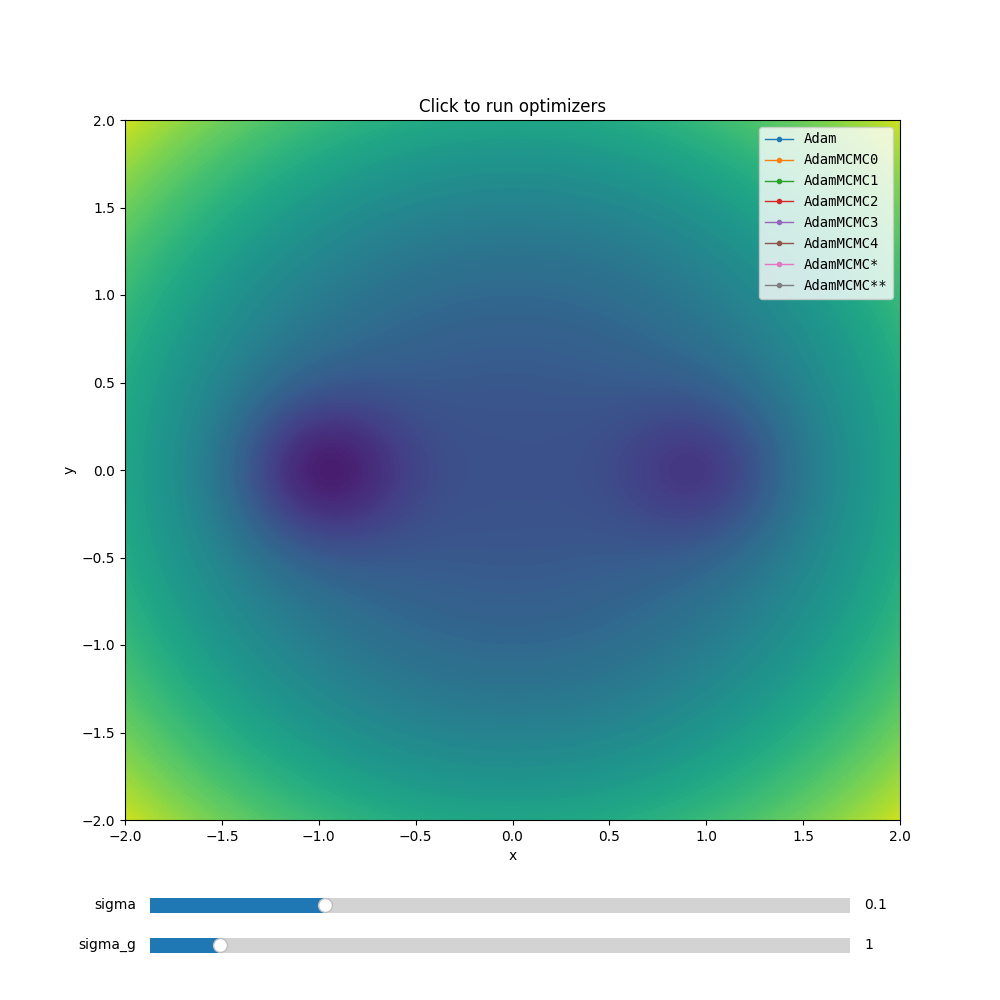

In [198]:
grid_length = 0.02
nx = int((domain_x[1] - domain_x[0]) / grid_length)
ny = int((domain_y[1] - domain_y[0]) / grid_length)
xs = np.linspace(domain_x[0], domain_x[1], nx)
ys = np.linspace(domain_y[0], domain_y[1], ny)
X, Y = np.meshgrid(xs, ys)
Z = f(X, Y)

contour_step = 0.1
levels = np.arange(domain_f[0], domain_f[1], contour_step)

figsize = (10, 10)
fig, ax = plt.subplots(figsize=figsize)
fig.subplots_adjust(bottom=0.18)  # make room for sliders

ax.contourf(X, Y, Z, levels=levels)
ax.set_xlim(domain_x)
ax.set_ylim(domain_y)
ax.set_title("Click to run optimizers")
ax.set_xlabel("x")
ax.set_ylabel("y")

# --- sliders ---
ax_sigma   = fig.add_axes([0.15, 0.08, 0.70, 0.03])
ax_sigma_g = fig.add_axes([0.15, 0.04, 0.70, 0.03])

s_sigma = Slider(ax_sigma, "sigma", 0.0, 0.4, valinit=sigma, valstep=0.001)
s_sigma_g = Slider(ax_sigma_g, "sigma_g", 0.0, 10.0, valinit=sigma_g, valstep=0.1)

# Register any number of path functions here:
# IMPORTANT: these functions must accept sigma and sigma_g as keyword args (or **kwargs),
# e.g. def get_adammcmc_path(x0, y0, sigma=..., sigma_g=..., ...): ...
PATH_FNS = {
    "Adam": get_adam_path,
    "AdamMCMC0": get_adammcmc_path,
    "AdamMCMC1": get_adammcmc_path,
    "AdamMCMC2": get_adammcmc_path,
    "AdamMCMC3": get_adammcmc_path,
    "AdamMCMC4": get_adammcmc_path,
    "AdamMCMC*": get_adammcmcstar_path,
    "AdamMCMC**": get_adammcmcstarstar_path,
}

def _legend_label(name: str, ar_post: float, ar_full: float) -> str:
    return f"{name:<10s} {ar_post:.3f} / {ar_full:.3f}"

paths_artists = {}
burnin_artists = {}

for name in PATH_FNS:
    (line,) = ax.plot([], [], lw=1, marker="o", ms=3, label=name)
    paths_artists[name] = line

    (star,) = ax.plot(
        [], [],
        ls="None",
        marker="s",
        ms=6,
        color=line.get_color(),  # same color as line
        mec="k",
        mew=0.6,
        label="_nolegend_",
        zorder=line.get_zorder() + 1,
    )
    burnin_artists[name] = star

ax.legend(loc="upper right", framealpha=0.8, prop={"family": "monospace"})

_last_click = None  # (x0, y0)

def run_paths(x0, y0):
    sigma   = float(s_sigma.val)
    sigma_g = float(s_sigma_g.val)

    for name, fn in PATH_FNS.items():
        path = fn(x0, y0, sigma=sigma, sigma_g=sigma_g)

        paths_artists[name].set_data(path[burnin:, 0], path[burnin:, 1])
        burnin_artists[name].set_data([path[burnin, 0]], [path[burnin, 1]])

        ar_burnin = float(get_acceptance_rate(path[burnin:, :]))
        ar_full = float(get_acceptance_rate(path))
        paths_artists[name].set_label(_legend_label(name, ar_burnin, ar_full))

    ax.legend(loc="upper right", framealpha=0.8, prop={"family": "monospace"})

def on_click(event):
    global _last_click
    if event.inaxes != ax or event.xdata is None or event.ydata is None:
        return
    _last_click = (event.xdata, event.ydata)
    run_paths(*_last_click)
    fig.canvas.draw_idle()

cid = fig.canvas.mpl_connect("button_press_event", on_click)
plt.show()
